In [28]:
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import pandas as pd
from enum import Enum
import graphviz as gv
from langchain.prompts.chat import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain, ConversationChain
from langchain.memory import ConversationBufferMemory
 
load_dotenv()

True

In [2]:
llm = ChatOpenAI(model_name="gpt-4")

In [34]:
%%html
<iframe src="https://python.langchain.com/docs/modules/model_io/models/llms/" width="1200" height="400"></iframe>


# A Simple Prompt
For this example, we will ask `ChatGPT` to create a small village in a particular location, in a particular year, and with a specified number of inhabitants.

In [36]:
%%html
<iframe src="https://python.langchain.com/docs/modules/model_io/prompts/prompt_templates/" width="1200" height="400"></iframe>


In [3]:
PROMPT_FORMAT = """
Create a village in {location} in the year {year}. Describe {population} villagers along with their family relations to one another.
"""

simple_prompt = PromptTemplate.from_template(PROMPT_FORMAT)
simple_prompt_with_values = simple_prompt.format_prompt(
    location="Yorkshire, England",
    year=900,
    population=10,
)

In [4]:
response = llm(simple_prompt_with_values.to_messages())
response.content

"Village Name: Yorkthorpe\n\n1. Eadric: Eadric is the village leader, a man in his late 50s, wise and respected by all. He inherited the leadership from his late father, Aelred. He is married to Hilda and they have three children. \n\n2. Hilda: Hilda is Eadric's wife, a woman of grace and kindness. She is known for her herbal remedies and healing abilities. She is the mother of Aelfric, Cynewise, and Elfrida.\n\n3. Aelfric: The eldest son of Eadric and Hilda, Aelfric is a brave and skilled warrior. At 30 years old, he is preparing to take over his father's position as village leader. He is married to Leofrun and they have two children.\n\n4. Cynewise: Cynewise is the only daughter of Eadric and Hilda. She is 28 years old, beautiful, and known for her skills in weaving. She is married to Godric and they have one son.\n\n5. Elfrida: Elfrida is the youngest child of Eadric and Hilda, about 18 years old. She is intelligent, curious, and dreams of exploring beyond the borders of Yorkthorpe.

# A Simple Prompt with Parsed Outputs

## Pydantic: A Model and Parser

In [29]:
%%html
<iframe src="https://docs.pydantic.dev/latest/" width="1200" height="400"></iframe>


### Add a "format instructions" parameter to the prompt.

In [5]:
class Villager(BaseModel):
    name: str
    age: int
    sex: str
    occupation: str
    ethnicity: str


class RelationshipType(Enum):
    SPOUSE_OF = "spouse of"
    PARENT_OF = "parent of"


class Relationship(BaseModel):
    subject_name: str = Field(
        "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)"
    )
    object_name: str = Field(
        "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)"
    )
    type: RelationshipType


class Village(BaseModel):
    name: str
    description: str
    county: str
    year: int
    villagers: list[Villager]
    relationships: list[Relationship]


pydantic_parser = PydanticOutputParser(pydantic_object=Village)

In [33]:
%%html
<iframe src="https://python.langchain.com/docs/modules/model_io/output_parsers/pydantic" width="1200" height="400"></iframe>


In [6]:
PROMPT_FORMAT_FOR_PARSING = (
    PROMPT_FORMAT
    + "\n{format_instructions}\nThe output should not deviate from this format in any way."
)
PROMPT_FORMAT_FOR_PARSING

'\nCreate a village in {location} in the year {year}. Describe {population} villagers along with their family relations to one another.\n\n{format_instructions}\nThe output should not deviate from this format in any way.'

In [7]:
prompt = PromptTemplate.from_template(PROMPT_FORMAT_FOR_PARSING)
prompt_with_values = prompt.format_prompt(
    location="Jórvík",
    year=900,
    population=10,
    format_instructions=pydantic_parser.get_format_instructions(),
)

In [22]:
prompt_with_values.to_messages()

[HumanMessage(content='\nCreate a village in Jórvík in the year 900. Describe 10 villagers along with their family relations to one another.\n\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"Relationship": {"properties": {"subject_name": {"default": "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Subject Name", "type": "string"}, "object_name": {"default": "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Object Name", "type": "string"}, "type": {"$ref": "#/$defs/RelationshipType

In [8]:
response_to_parse = llm(prompt_with_values.to_messages())

In [32]:
response_to_parse

AIMessage(content='{\n  "name": "Jórvík Village",\n  "description": "A small Viking village in Jórvík surrounded by beautiful landscapes and rivers.",\n  "county": "Yorkshire",\n  "year": 900,\n  "villagers": [\n    {\n      "name": "Erik",\n      "age": 45,\n      "sex": "Male",\n      "occupation": "Blacksmith",\n      "ethnicity": "Norse"\n    },\n    {\n      "name": "Astrid",\n      "age": 40,\n      "sex": "Female",\n      "occupation": "Weaver",\n      "ethnicity": "Norse"\n    },\n    {\n      "name": "Bjorn",\n      "age": 20,\n      "sex": "Male",\n      "occupation": "Warrior",\n      "ethnicity": "Norse"\n    },\n    {\n      "name": "Ingrid",\n      "age": 18,\n      "sex": "Female",\n      "occupation": "Farmer",\n      "ethnicity": "Norse"\n    },\n    {\n      "name": "Ragnar",\n      "age": 50,\n      "sex": "Male",\n      "occupation": "Chieftain",\n      "ethnicity": "Norse"\n    },\n    {\n      "name": "Lagertha",\n      "age": 48,\n      "sex": "Female",\n      "o

In [9]:
village = pydantic_parser.parse(response_to_parse.content)
village

Village(name='Jórvík Village', description='A small Viking village in Jórvík surrounded by beautiful landscapes and rivers.', county='Yorkshire', year=900, villagers=[Villager(name='Erik', age=45, sex='Male', occupation='Blacksmith', ethnicity='Norse'), Villager(name='Astrid', age=40, sex='Female', occupation='Weaver', ethnicity='Norse'), Villager(name='Bjorn', age=20, sex='Male', occupation='Warrior', ethnicity='Norse'), Villager(name='Ingrid', age=18, sex='Female', occupation='Farmer', ethnicity='Norse'), Villager(name='Ragnar', age=50, sex='Male', occupation='Chieftain', ethnicity='Norse'), Villager(name='Lagertha', age=48, sex='Female', occupation='Shield-maiden', ethnicity='Norse'), Villager(name='Ivar', age=22, sex='Male', occupation='Warrior', ethnicity='Norse'), Villager(name='Helga', age=21, sex='Female', occupation='Herbalist', ethnicity='Norse'), Villager(name='Floki', age=35, sex='Male', occupation='Boatbuilder', ethnicity='Norse'), Villager(name='Siggy', age=30, sex='Femal

### So how does this work?
It's not magic. The `pydantic_parser` simply provides instructions that are formatted by the templates `{format_instructions}` parameter and `ChatGPT` follows these ... usually.

In [10]:
pydantic_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"Relationship": {"properties": {"subject_name": {"default": "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Subject Name", "type": "string"}, "object_name": {"default": "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Object Name", "type": "string"}, "type": {"$ref": "#/$defs/RelationshipType"}}, "required": ["type"], "title": "Relationship", "type": "object"}, "RelationshipType": {"enum": ["spouse of", "parent of"], "title": "Relat

## Pandas

In [11]:
villagers_df = pd.DataFrame(map(BaseModel.model_dump, village.villagers)).set_index(
    "name"
)
villagers_df

,age,sex,occupation,ethnicity
name,,,,
Erik,45,Male,Blacksmith,Norse
Astrid,40,Female,Weaver,Norse
Bjorn,20,Male,Warrior,Norse
Ingrid,18,Female,Farmer,Norse
Ragnar,50,Male,Chieftain,Norse
Lagertha,48,Female,Shield-maiden,Norse
Ivar,22,Male,Warrior,Norse
Helga,21,Female,Herbalist,Norse
Floki,35,Male,Boatbuilder,Norse


In [12]:
relationships_df = pd.DataFrame(map(BaseModel.model_dump, village.relationships))
relationships_df

,subject_name,object_name,type
0,Erik,Astrid,RelationshipType.SPOUSE_OF
1,Erik,Bjorn,RelationshipType.PARENT_OF
2,Astrid,Ingrid,RelationshipType.PARENT_OF
3,Ragnar,Lagertha,RelationshipType.SPOUSE_OF
4,Ragnar,Ivar,RelationshipType.PARENT_OF
5,Lagertha,Helga,RelationshipType.PARENT_OF
6,Floki,Siggy,RelationshipType.SPOUSE_OF


## Graphviz

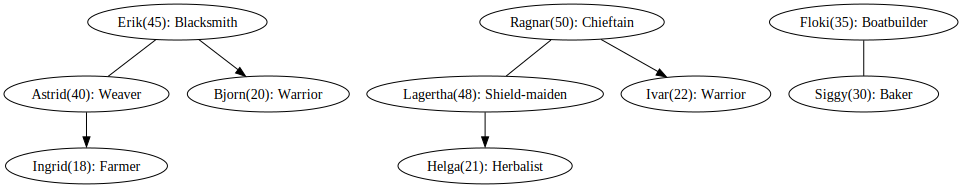

In [13]:
g = gv.Digraph()
g.graph_attr["rankdir"] = "TB"

for v in village.villagers:
    g.node(v.name, label=f"{v.name}({v.age}): {v.occupation}")

for r in village.relationships:
    arrowhead = "normal" if r.type == RelationshipType.PARENT_OF else "none"
    g.edge(head_name=r.object_name, tail_name=r.subject_name, arrowhead=arrowhead)

g

## Combining Pandas and Graphviz

In [14]:
import json
from IPython.display import JSON

ARROW_STYLE_LOOKUP = {
    RelationshipType.SPOUSE_OF: "none",
}

STYLE_LOOKUP = {
    RelationshipType.SPOUSE_OF: "bold",
}


def display_village(village: Village):
    # top level description of village
    village_info = json.loads(village.model_dump_json())

    # the table of villagers
    df = pd.DataFrame(map(BaseModel.model_dump, village.villagers)).set_index("name")

    g = gv.Digraph()
    g.graph_attr["rankdir"] = "TB"

    # the family trees of villagers
    for v in village.villagers:
        g.node(v.name, label=f"{v.name}({v.age}): {v.occupation}")

    for r in village.relationships:
        g.edge(
            head_name=r.object_name,
            tail_name=r.subject_name,
            arrowhead=ARROW_STYLE_LOOKUP.get(r.type, "normal"),
            style=STYLE_LOOKUP.get(r.type, "solid"),
        )

    display(JSON(village_info), df, g)

<IPython.core.display.JSON object>

,age,sex,occupation,ethnicity
name,,,,
Erik,45,Male,Blacksmith,Norse
Astrid,40,Female,Weaver,Norse
Bjorn,20,Male,Warrior,Norse
Ingrid,18,Female,Farmer,Norse
Ragnar,50,Male,Chieftain,Norse
Lagertha,48,Female,Shield-maiden,Norse
Ivar,22,Male,Warrior,Norse
Helga,21,Female,Herbalist,Norse
Floki,35,Male,Boatbuilder,Norse


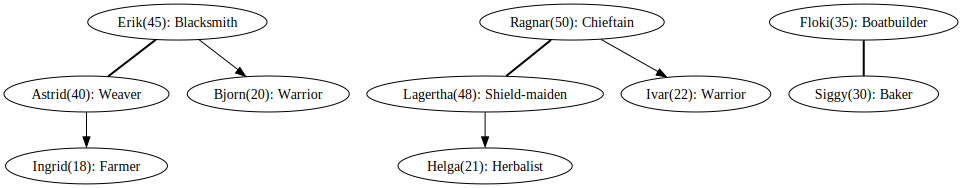

In [16]:
display_village(village=village)

## Chains

These steps can be combined in single chain object.

In [37]:
%%html
<iframe src="https://python.langchain.com/docs/modules/chains/" width="1200" height="400"></iframe>


In [17]:
prompt = PromptTemplate(
    template=PROMPT_FORMAT_FOR_PARSING,
    input_variables=["location", "year", "population"],
    partial_variables={
        "format_instructions": pydantic_parser.get_format_instructions()
    },
)
chain = LLMChain(llm=llm, prompt=prompt, output_parser=pydantic_parser, verbose=True)

In [18]:
village = chain.run(location="Hertfordshire, England", year=1086, population=30)
village



> Entering new LLMChain chain...
Prompt after formatting:

Create a village in Hertfordshire, England in the year 1086. Describe 30 villagers along with their family relations to one another.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"Relationship": {"properties": {"subject_name": {"default": "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Subject Name", "type": "string"}, "object_name": {"default": "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Object Name", "type": "string"}

Village(name='Ashridge', description='A small farming village in Hertfordshire, England', county='Hertfordshire', year=1086, villagers=[Villager(name='Albert', age=50, sex='male', occupation='farmer', ethnicity='english'), Villager(name='Bertha', age=45, sex='female', occupation="farmer's wife", ethnicity='english'), Villager(name='Cuthbert', age=22, sex='male', occupation='blacksmith', ethnicity='english'), Villager(name='Dorothy', age=20, sex='female', occupation='weaver', ethnicity='english'), Villager(name='Edward', age=18, sex='male', occupation="farmer's son", ethnicity='english'), Villager(name='Felicity', age=16, sex='female', occupation="farmer's daughter", ethnicity='english'), Villager(name='Geoffrey', age=35, sex='male', occupation='carpenter', ethnicity='english'), Villager(name='Helen', age=33, sex='female', occupation="carpenter's wife", ethnicity='english'), Villager(name='Isaac', age=12, sex='male', occupation="carpenter's son", ethnicity='english'), Villager(name='Jan

<IPython.core.display.JSON object>

,age,sex,occupation,ethnicity
name,,,,
Albert,50,male,farmer,english
Bertha,45,female,farmer's wife,english
Cuthbert,22,male,blacksmith,english
Dorothy,20,female,weaver,english
Edward,18,male,farmer's son,english
Felicity,16,female,farmer's daughter,english
Geoffrey,35,male,carpenter,english
Helen,33,female,carpenter's wife,english
Isaac,12,male,carpenter's son,english


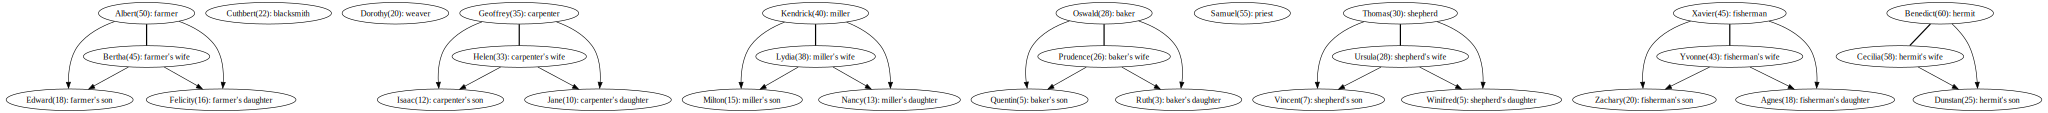

In [19]:
display_village(village=village)

# Final Comments
- Hard to get `ChatGPT` to give you what you want and ask for.
    - For higher numbers of villagers, will often shorten the list even though there should be plenty of tokens left.
- Can sometimes include "Sure! Here you go..." type verbage that makes it difficult to parse outputs.
    - Will often ignore requests to not do so.
- While this may be useful for fixtures in unit testing and other small applications, this may be limitted when larger, richer fake datasets are needed.